In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import histlite as hl

import pickle

import uproot

import scipy.interpolate as interp

from configparser import ConfigParser

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (7,6)


# Load config file and grab the threshold parameters:
cfg_file = '/g/g20/lenardo1/software/sis3316_replay/config_tim_daniels.ini'
config = ConfigParser()
config.read(cfg_file)
sections = config.sections()

channel_names = [section for section in sections if 'ch' in section]
desired_variables = ['ngcut','ngain_m','ngain_b','th_deg']
config_params = {}

for ch in channel_names:
    
    param_dict = {}
    for var in desired_variables:
        param_dict[var] = float(config.get(ch,var))
    config_params[ch] = param_dict


# Define functions

In [2]:
def GetPulseHeightThresholdValue( ngain_m, ngain_b, cs_factor = 0.5 ):
    
    # cs_factor defines the threhsold energy...default is 0.5, which sets the 
    # threshold at 1/2 of the Cs compton edge
    return 0.477 * cs_factor * ngain_m + ngain_b



def GetPSDCutMask( dataframe, cut_a, cut_b, cut_c ):
    xfit = np.linspace(0.,16000.,200)
    quadratic_PH = (cut_a*dataframe['ndet_PH']**2 + \
                    cut_b*dataframe['ndet_PH'] + \
                    cut_c)
    inverse_psd = 1./dataframe['ndet_PSD']
    mask = ( inverse_psd > quadratic_PH ) & (inverse_psd < 0.4)
    return mask


def nTOF_vs_energy( energy ):
    distance = 13. # m
    c = 3e8 # m/s
    m_N = 939.56563 # MeV
    TOF = distance / ( c*np.sqrt( 1 - ( 1 / (energy/m_N + 1) )**2  ) )
    return TOF

def Energy_vs_nTOF( TOF ):
    distance = 13. # m
    c = 3e8 # m/s
    m_N = 939.56563 # MeV
    energy = m_N * ( 1 / np.sqrt(1-(distance/TOF/c)**2) - 1 )
    return energy


def Qvalue():
    m_Xe = 135.907219 # amu
    m_Cs = 135.9073116 # amu
    m_e = 0.511 # MeV
    m_p = 938.272 # MeV
    m_n = 939.565 # MeV
    
    Z_Cs = 55
    Z_Xe = 54
    
    MeV_per_amu = 931.5 # MeV/amu
    
    return (m_Cs * MeV_per_amu - (Z_Cs * m_e) + m_n) - (m_Xe * MeV_per_amu - (Z_Xe * m_e) + m_p)
    #return (m_Cs * MeV_per_amu + (Z_Cs * m_e)) - (m_Xe * MeV_per_amu + (Z_Xe * m_e))
    
    
def TaQvalue():
    m_Ta = 180.9479958 # amu
    m_W = 180.948197 # amu
    m_e = 0.511 # MeV
    m_p = 938.272 # MeV
    m_n = 939.565 # MeV
    
    Z_Ta = 73
    Z_W = 74
    
    
    MeV_per_amu = 931.5
    
    return (m_W * MeV_per_amu - (Z_W * m_e) + m_n) - (m_Ta * MeV_per_amu - (Z_Ta * m_e) + m_p)
    
    


In [3]:
print(Qvalue())
print(TaQvalue())

0.8682569000229705
0.9694178000208922


# Load in parameters from external files and set up cuts

### PSD cut

In [4]:
psd_cut_params = np.genfromtxt('analysis_data/30180_psd_cut_parameters.csv',delimiter=',',skip_header=1)

psd_cut_ch = psd_cut_params[:,0]
psd_cut_a = psd_cut_params[:,1]
psd_cut_b = psd_cut_params[:,2]
psd_cut_c = psd_cut_params[:,3]

# This function says whether or not an event passes the PSD cut for its channel.
# Returns a cut that represents the OR of all the PSD cuts for all channels.
def GetFullPSDCutMask( dataframe, channel_names ):
    
    psd_cut_mask = np.zeros(len(dataframe),dtype=bool)
    
    cuts_list = []
    
    for ch in channel_names:
        ch_num = float(ch[2:])
        
        # a,b,c are parameters of the function 1/PSD = a(PH)^2 + b(PH) + c
        thisch_idx = np.where(psd_cut_ch == ch_num)[0]
        a = psd_cut_a[thisch_idx]
        b = psd_cut_b[thisch_idx]
        c = psd_cut_c[thisch_idx]
        
        channel_cut = (dataframe['ndet_ch'] == ch_num)
        psd_cut = GetPSDCutMask(dataframe,a,b,c)
        
        cuts_list.append(channel_cut&psd_cut)
        
    for cut in cuts_list:
        psd_cut_mask = psd_cut_mask | cut
        
    return psd_cut_mask
        
    
    


### Pulse height cut

In [5]:
# Load config file and grab the parameters for setting the thresholds:
cfg_file = '/g/g20/lenardo1/software/sis3316_replay/config_tim_daniels.ini'
config = ConfigParser()
config.read(cfg_file)
sections = config.sections()

channel_names = [section for section in sections if 'ch' in section]
desired_variables = ['ngcut','ngain_m','ngain_b','th_deg']
config_params = {}

for ch in channel_names:
    
    param_dict = {}
    for var in desired_variables:
        param_dict[var] = float(config.get(ch,var))
    config_params[ch] = param_dict
    
    
def GetFullPHCutMask( dataframe, channel_names, cs_factor=1., upper_ph_cut=12000. ):
    
    ph_cut_mask = np.zeros(len(dataframe),dtype=bool)
    
    cuts_list = []
    
    for ch in channel_names:
        
        chnum = float(ch[2:])
        channel_cut = (dataframe['ndet_ch']==chnum)
        
        m = config_params[ch]['ngain_m']
        b = config_params[ch]['ngain_b']
        
        ph_cut = (dataframe['ndet_PH'] > GetPulseHeightThresholdValue( m, b, cs_factor=cs_factor)) &\
                    (dataframe['ndet_PH'] < upper_ph_cut)
        
        cuts_list.append(ph_cut&channel_cut)
        
    for cut in cuts_list:
        ph_cut_mask = ph_cut_mask | cut
        
    return ph_cut_mask
        

### Getting T0 from the gamma flash

In [6]:
gamma_flash_parameters = np.genfromtxt('analysis_data/gamma_flash_peak_fits_30180.csv',delimiter=',')
gamma_flash_array = gamma_flash_parameters[:,[0,4]]

t0_array = gamma_flash_array

# Correct the t0 for the travel time of the gammas across the 13 m flight path.
d = 13. #m 
c = 2.998e8 #m/s

t0_array[:,1] = t0_array[:,1] - d/c*1e9

# Load in target-in data

In [7]:


datapath = '/p/lustre1/lenardo1/tunl_cs136_data/replayed/'

signal_datasets = ['30175',
                  '30176',
                  '30177',
                  '30178',
                  '30179',
                  '30180',
                  '30181']



bkg_datasets = ['30254',
               '30255',
               '30256',
               '30257',
               '30258',
               '30259',
               '30260',
               '30261']

df_dict = {}

# If the data hasn't already been saved in a easier-to-read file,
# load it in from the ROOT files
if 'pandas_datasets_30175-30181.pkl' not in os.listdir(datapath):

    for dataset in signal_datasets:

        print('Loading run{}...'.format(dataset))

        dsname = datapath + 'slurm_run{}'.format(dataset)

        rootfiles = [filename for filename in os.listdir(dsname) if filename.endswith('.root') ]

        data_list = []

        for thisfile in rootfiles:
            #print('\tOpening {}'.format(thisfile))

            fullpath = dsname + '/' + thisfile

            data_list.append( \
                    uproot.open(fullpath)['ndet_events'].arrays( ["*"], \
                                                                outputtype=pd.DataFrame ) )

        data = pd.concat(data_list,ignore_index=True)

        df_dict[dataset] = data
    
    with open(datapath+'pandas_datasets_30175-30181.pkl','wb') as pklfile:
        pickle.dump(bkg_df_dict,pklfile)
        
# Otherwise, just load in the pkl file.
else:
    with open(datapath+'pandas_datasets_30175-30181.pkl','rb') as pklfile:
        df_dict = pickle.load(pklfile)
        
        
        
bkg_df_dict = {}

# If the data hasn't already been saved in a easier-to-read file,
# load it in from the ROOT files
if 'pandas_datasets_30254-30262.pkl' not in os.listdir(datapath):

    for dataset in bkg_datasets:

        print('Loading run{}...'.format(dataset))

        dsname = datapath + 'slurm_run{}'.format(dataset)

        rootfiles = [filename for filename in os.listdir(dsname) if filename.endswith('.root') ]

        data_list = []

        for thisfile in rootfiles:
            #print('\tOpening {}'.format(thisfile))

            fullpath = dsname + '/' + thisfile

            data_list.append( \
                    uproot.open(fullpath)['ndet_events'].arrays( ["*"], \
                                                                outputtype=pd.DataFrame ) )

        data = pd.concat(data_list,ignore_index=True)

        bkg_df_dict[dataset] = data
        
    with open(datapath+'pandas_datasets_30254-30262.pkl','wb') as pklfile:
        pickle.dump(bkg_df_dict,pklfile)
        
# Otherwise, just load in the pkl file.
else:
    with open(datapath+'pandas_datasets_30254-30262.pkl','rb') as pklfile:
        bkg_df_dict = pickle.load(pklfile)
        

In [8]:
df_dict['30175'].head()

summed_df = pd.concat( [df for dataset,df in df_dict.items()], ignore_index=True)

bkg_summed_df = pd.concat( [df for dataset,df in bkg_df_dict.items()], ignore_index=True)



In [9]:
# Get Corrected TOF
corrected_tof = np.zeros(len(summed_df))

for ch in channel_names:
    print(ch)
    ch_float = float(ch[2:])
    
    datamask = (summed_df['ndet_ch'] == ch_float)
    
    correction_mask = (t0_array[:,0] == ch_float)
    correction = t0_array[correction_mask,1][0]
    
    corrected_tof[datamask] = np.fmod(summed_df['ndet_tof'].loc[datamask].values + (3200.-correction),3200.)
    
    
summed_df['corrected_tof'] = corrected_tof
summed_df['PSD cut'] = GetFullPSDCutMask(summed_df,channel_names)
summed_df['Pulse height cut'] = GetFullPHCutMask( summed_df, channel_names, cs_factor=1. )
summed_df['neutron_energy'] = Energy_vs_nTOF( summed_df['corrected_tof'] * 1.e-9 )





ch0
ch1
ch2
ch3
ch4
ch5
ch6
ch7
ch8
ch9
ch10
ch16
ch17
ch18
ch19
ch20
ch21
ch27
ch30
ch42


/g/g20/lenardo1/localpythonpackages/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in sqrt


In [10]:
#Same for bkg
corrected_tof = np.zeros(len(bkg_summed_df))

for ch in channel_names:
    print(ch)
    ch_float = float(ch[2:])
    
    datamask = (bkg_summed_df['ndet_ch'] == ch_float)
    
    correction_mask = (t0_array[:,0] == ch_float)
    correction = t0_array[correction_mask,1][0]
    
    corrected_tof[datamask] = np.fmod(bkg_summed_df['ndet_tof'].loc[datamask].values + (3200.-correction),3200.)
    
    
bkg_summed_df['corrected_tof'] = corrected_tof
bkg_summed_df['PSD cut'] = GetFullPSDCutMask(bkg_summed_df,channel_names)
bkg_summed_df['Pulse height cut'] = GetFullPHCutMask( bkg_summed_df, channel_names, cs_factor=1. )
bkg_summed_df['neutron_energy'] = Energy_vs_nTOF( bkg_summed_df['corrected_tof'] * 1.e-9 )

ch0
ch1
ch2
ch3
ch4
ch5
ch6
ch7
ch8
ch9
ch10
ch16
ch17
ch18
ch19
ch20
ch21
ch27
ch30
ch42


/g/g20/lenardo1/localpythonpackages/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in sqrt


In [11]:


summed_df.head()

,ndet_ch,ndet_PH,ndet_E,ndet_ts,ndet_tof,ndet_PSD,ndet_PSD_cut,ndet_flash,ndet_true_time,corrected_tof,PSD cut,Pulse height cut,neutron_energy
0,16.0,16383.0,0.0,9.477739e+11,324.800002,7.512032,9.25,2456.0,1068.800002,1114.052568,False,False,0.711579
1,17.0,1398.0,0.0,9.478195e+11,3193.606196,5.487665,10.50,2450.0,743.606196,789.009969,True,False,1.420235
2,16.0,16383.0,0.0,9.478202e+11,188.688672,8.454452,9.25,2456.0,932.688672,977.941237,False,False,0.923753
3,1.0,1891.0,0.0,9.478226e+11,2950.410476,5.605349,9.00,2449.0,501.410476,547.206654,True,True,2.959969
4,20.0,1032.0,0.0,9.478228e+11,3119.240247,4.684425,9.00,2444.0,675.240247,720.473605,True,False,1.704062


(2700.0, 2900.0)

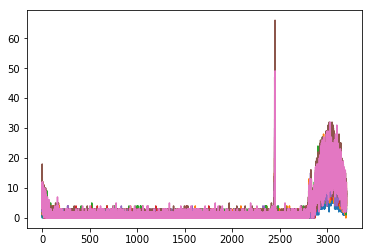

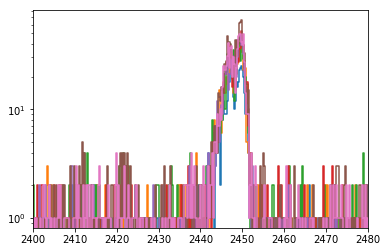

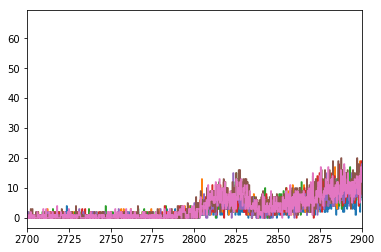

In [12]:
hdict = {}

for dataset in signal_datasets:
    mask = df_dict[dataset]['ndet_ch'] == 1.
    
    hdict[dataset] = hl.hist( df_dict[dataset]['ndet_tof'].loc[mask], \
                                bins = np.linspace(0.,3200.,3200*4 + 1))
    
    plt.figure(1)
    hl.plot1d( hdict[dataset], label=dataset )
    
    plt.figure(2)
    hl.plot1d( hdict[dataset], label=dataset )
    
    plt.figure(3)
    hl.plot1d( hdict[dataset], label=dataset )
    
    
plt.figure(2)
plt.xlim(2400.,2480.)
plt.yscale('log')

plt.figure(3)
plt.xlim(2700.,2900.)


(-1.0, 6.0)

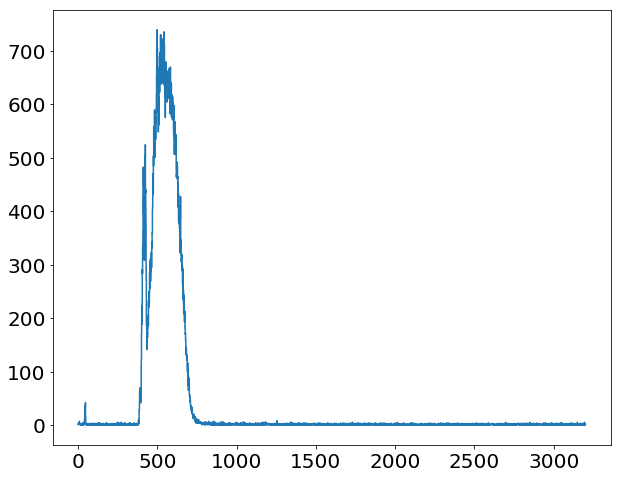

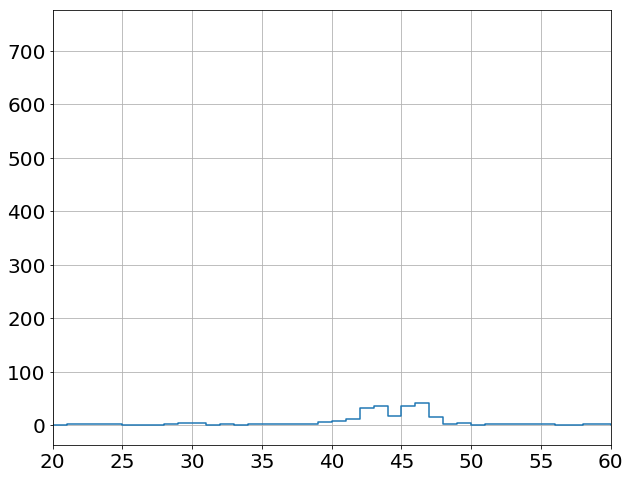

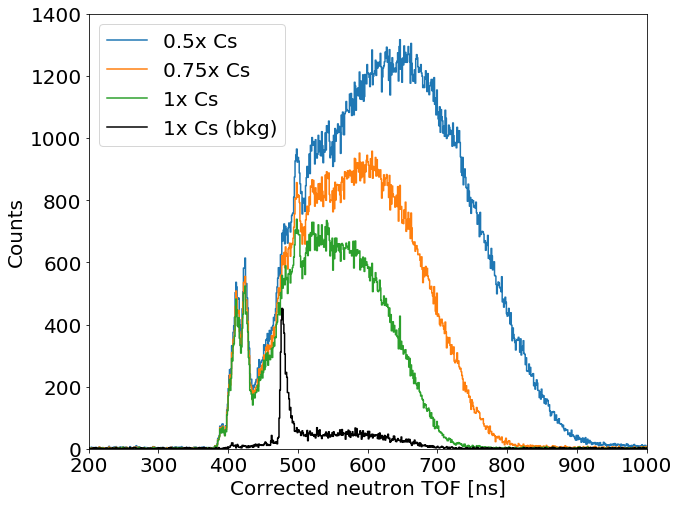

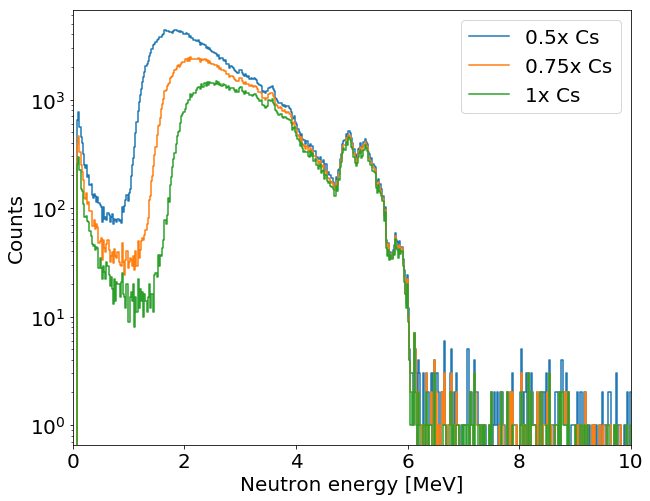

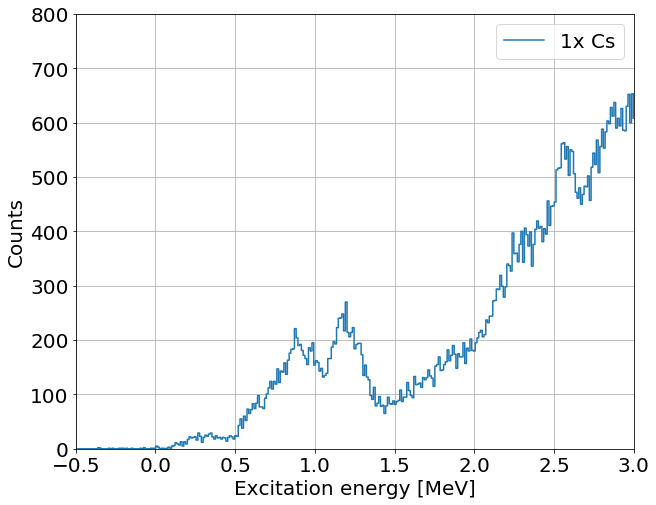

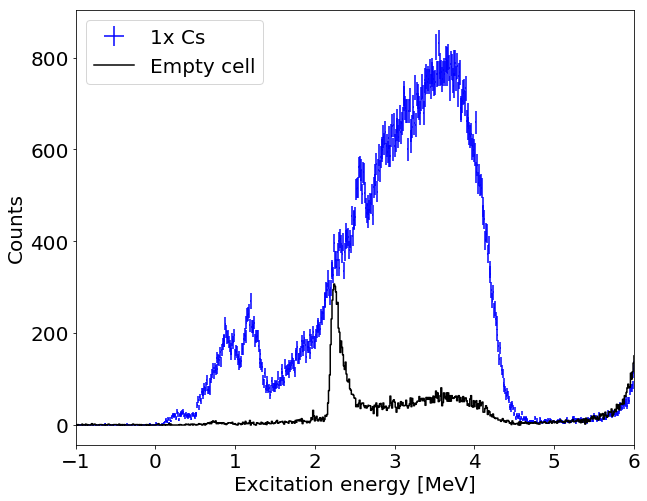

In [20]:
plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = (10,8)

mask = (summed_df['ndet_ch'] == 0.)|(summed_df['ndet_ch'] == 1.)|(summed_df['ndet_ch'] == 2.)

mask = mask & summed_df['PSD cut']
        

PH_half_cs = GetFullPHCutMask( summed_df, channel_names, cs_factor=0.5 )
PH_0p75_cs = GetFullPHCutMask( summed_df, channel_names, cs_factor=0.75 )
PH_1_cs = GetFullPHCutMask( summed_df, channel_names, cs_factor=1.0 )

hsum_0_0p5_cs = hl.hist( summed_df['corrected_tof'].loc[ mask & PH_half_cs ], \
                            bins = np.linspace(0.,3200.,3201))


hsum_0_0p75_cs = hl.hist( summed_df['corrected_tof'].loc[ mask & PH_0p75_cs ], \
                            bins = np.linspace(0.,3200.,3201))

hsum_0_1_cs = hl.hist( summed_df['corrected_tof'].loc[ mask & PH_1_cs ], \
                            bins = np.linspace(0.,3200.,3201))

bkg_mask = (bkg_summed_df['ndet_ch'] == 0.)|(bkg_summed_df['ndet_ch'] == 1.)|(bkg_summed_df['ndet_ch'] == 2.)
bkg_mask = bkg_mask & bkg_summed_df['PSD cut']
bkg_PH_1_cs = GetFullPHCutMask( bkg_summed_df, channel_names, cs_factor=1.0 )

hsum_0_1_cs_bkg = hl.hist( bkg_summed_df['corrected_tof'].loc[ bkg_mask & bkg_PH_1_cs ], \
                            bins = np.linspace(0.,3200.,3201))


plt.figure(1)
hl.plot1d(hsum_0_1_cs)

plt.figure(2)
hl.plot1d(hsum_0_1_cs)
plt.xlim(20.,60.)
plt.grid()


plt.figure(3)
hl.plot1d(hsum_0_0p5_cs,label='0.5x Cs')
plt.xlim(200.,1000.)
plt.ylim(0.,1400.)

hl.plot1d(hsum_0_0p75_cs,label='0.75x Cs')
hl.plot1d(hsum_0_1_cs,label='1x Cs')

hl.plot1d(hsum_0_1_cs_bkg, label='1x Cs (bkg)', color='k')

plt.xlabel('Corrected neutron TOF [ns]')
plt.ylabel('Counts')
plt.legend()


plt.figure(4)
h_energy_0p5cs = hl.hist( summed_df['neutron_energy'].loc[ mask & PH_half_cs ],\
                         bins=np.linspace(0.,10.,500) )

h_energy_0p75cs = hl.hist( summed_df['neutron_energy'].loc[ mask & PH_0p75_cs ],\
                         bins=np.linspace(0.,10.,500) )

h_energy_1cs = hl.hist( summed_df['neutron_energy'].loc[ mask & PH_1_cs ],\
                         bins=np.linspace(0.,10.,500) )

hl.plot1d(h_energy_0p5cs, label='0.5x Cs')
hl.plot1d(h_energy_0p75cs, label='0.75x Cs')
hl.plot1d(h_energy_1cs, label='1x Cs')


plt.legend()
plt.xlabel('Neutron energy [MeV]')
plt.ylabel('Counts')
plt.xlim(0.,10.)
#plt.ylim(0.,1.05 * np.max(h_energy_0p5cs.values))
plt.yscale('log')


plt.figure(5)
nbins = 1000

h_ex_energy_0p5cs = hl.hist( 7. - Qvalue() - summed_df['neutron_energy'].loc[ mask & PH_half_cs ],\
                         bins=np.linspace(-1.,10.,nbins) )

h_ex_energy_0p75cs = hl.hist( 7. - Qvalue() - summed_df['neutron_energy'].loc[ mask & PH_0p75_cs ],\
                         bins=np.linspace(-1.,10.,nbins) )

h_ex_energy_1cs = hl.hist( 7. - Qvalue() - summed_df['neutron_energy'].loc[ mask & PH_1_cs ],\
                         bins=np.linspace(-1.,10.,nbins) )

# hl.plot1d(h_ex_energy_0p5cs, label='0.5x Cs')
# hl.plot1d(h_ex_energy_0p75cs, label='0.75x Cs')
hl.plot1d(h_ex_energy_1cs, label='1x Cs')

plt.legend()
plt.xlabel('Excitation energy [MeV]')
plt.ylabel('Counts')

plt.ylim(0.,800.)
plt.xticks(np.linspace(-0.50,5.,12))
plt.xlim(-0.5,3.)
plt.grid()

plt.figure(6)


h_ex_energy_1cs_bkg = hl.hist( 7. - Qvalue() - bkg_summed_df['neutron_energy'].loc[ bkg_mask & bkg_PH_1_cs ],\
                         bins=np.linspace(-1.,10.,nbins) )

hl.plot1d(h_ex_energy_1cs, color='b', label='1x Cs', crosses=True)
hl.plot1d(h_ex_energy_1cs_bkg, color='k', label='Empty cell')
plt.legend()
plt.xlabel('Excitation energy [MeV]')
plt.ylabel('Counts')
plt.xlim(-1.,6.)
#plt.yscale('log')
                         


In [14]:
thresholds_list = [0.5,0.75,1.]


for threshold in thresholds_list

SyntaxError: invalid syntax (<ipython-input-14-8cbc2a53a429>, line 4)

In [ ]:
mask = (summed_df['ndet_ch'] == 19.)|(summed_df['ndet_ch'] == 20.)|(summed_df['ndet_ch'] == 21.)



hsum_19 = hl.hist( summed_df['corrected_tof'].loc[mask], \
                            bins = np.linspace(0.,3200.,3201))


plt.figure(1)

hl.plot1d(hsum_19)

plt.figure(2)
hl.plot1d(hsum_19)
plt.xlim(20.,60.)
plt.grid()


plt.figure(3)
hl.plot1d(hsum_19)
plt.xlim(200.,1000.)
plt.ylim(0.,800.)


In [ ]:
hl.plot1d(hsum_0)
hl.plot1d(hsum_19)
plt.xlim(300.,800.)
plt.ylim(10.,1500.)
plt.yscale('log')

xgaus = np.linspace(0.,1200.)
ygaus = 1400.*np.exp(-(xgaus-650.)**2/(2*100.**2))
plt.plot(xgaus,ygaus,'--k',linewidth=1)


In [ ]:
nbins=1601

mask = (summed_df['ndet_ch'] == 0.)|(summed_df['ndet_ch'] == 1.)|(summed_df['ndet_ch'] == 2.)
hsum_0 = hl.hist( summed_df['ndet_tof'].loc[mask]-summed_df['ndet_flash'].loc[mask], \
                            bins = np.linspace(0.,3200.,nbins))


mask = (summed_df['ndet_ch'] == 3.)|(summed_df['ndet_ch'] == 4.)|(summed_df['ndet_ch'] == 5.)
hsum_3 = hl.hist( summed_df['ndet_tof'].loc[mask]-summed_df['ndet_flash'].loc[mask], \
                            bins = np.linspace(0.,3200.,nbins))

mask = (summed_df['ndet_ch'] == 6.)|(summed_df['ndet_ch'] == 7.)|(summed_df['ndet_ch'] == 8.)
hsum_6 = hl.hist( summed_df['ndet_tof'].loc[mask]-summed_df['ndet_flash'].loc[mask], \
                            bins = np.linspace(0.,3200.,nbins))

mask = (summed_df['ndet_ch'] == 16.)|(summed_df['ndet_ch'] == 17.)|(summed_df['ndet_ch'] == 18.)
hsum_9 = hl.hist( summed_df['ndet_tof'].loc[mask]-summed_df['ndet_flash'].loc[mask], \
                            bins = np.linspace(0.,3200.,nbins))


mask = (summed_df['ndet_ch'] == 20.)|(summed_df['ndet_ch'] == 21.)|(summed_df['ndet_ch'] == 19.)
hsum_12 = hl.hist( summed_df['ndet_tof'].loc[mask]-summed_df['ndet_flash'].loc[mask], \
                            bins = np.linspace(0.,3200.,nbins))




In [ ]:
hl.plot1d(hsum_0*3/2,label='0deg')
hl.plot1d(hsum_3,label='3deg')
hl.plot1d(hsum_6,label='6deg')
hl.plot1d(hsum_9,label='9deg')
hl.plot1d(hsum_12,label='12deg')
plt.xlim(330.,400.)
plt.ylim(0.,3300.)
plt.legend()

In [ ]:
hsum_0sc = hsum_0*3/2

hl.plot1d(hsum_0sc/hsum_0sc,label='0deg')
hl.plot1d(hsum_3/hsum_0sc,label='3deg')
hl.plot1d(hsum_6/hsum_0sc,label='6deg')
hl.plot1d(hsum_9/hsum_0sc,label='9deg')
hl.plot1d(hsum_12/hsum_0sc,label='12deg')

plt.xlim(330.,400.)
plt.ylim(0.,2.)
plt.legend()

In [ ]:
nbins=3201

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (7,6)


psd_mask = (summed_df['ndet_PSD']>2.2) & \
            (summed_df['ndet_PSD']<9.) & \
            (summed_df['ndet_PH'] < 12000.) & \
            np.invert( (summed_df['ndet_PH']>8000.)&(summed_df['ndet_PSD']>6.) )
            

hsum_all = hl.hist( summed_df['ndet_tof'].loc[psd_mask]-summed_df['ndet_flash'].loc[psd_mask], \
                            bins = np.linspace(0.,3200.,nbins))

hl.plot1d(hsum_all,crosses=True)

plt.xlim(300.,400.)
plt.ylim(0.,1000.)



In [ ]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (12,11)


plt.plot( summed_df['ndet_PSD'].loc[psd_mask], summed_df['ndet_PH'].loc[psd_mask], 
         'o',color=(0.,0.,1.,0.04),markersize=1)